# This notebook provides the NN for the simulated events of M1 and M2 as defined in https://arxiv.org/abs/1911.09699

## Let's import everything and define the necessary functions

In [4]:
import os
import sys
import numpy as np 
import matplotlib as matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from statistics import mean
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.utils import np_utils

WORK_DIR='../data/'

In [2]:
def find_nearest(array, value):
    #This function takes a list and value and yields the index of the list element closer to the value
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx
    
def find_nearest2d(array1,value1,array2,value2):
    #This function takes two vectors of length Nrow*Ncolumns meant to represent each possible pair of points in a 2d plane 
    #and yields the index of the pair closer to (value1,value2)
    if(len(array1)==len(array2)):
        auxarray=np.zeros(len(array1))
        for i in range(len(array1)):
            auxarray[i]=np.sqrt((array1[i]-value1)**2+(array2[i]-value2)**2)#asi parametrizo acercarme a los puntos que yo quiero
        indaux=find_nearest(auxarray,0.0)
        return indaux
    else:
        return 'Not same length'

def kplus(a,b):
    #I'll use this in the demixer, it's only a shorthand
    return float(a/b)
    #return float(a/b)+np.sqrt((float(a*np.sqrt(b)/(b*b)))*(float(a*np.sqrt(b)/(b*b)))+(float(np.sqrt(a)/b))*(float(np.sqrt(a)/b)))
def demixer(list1,list2):
    #This is the demixer function which yields [[t1, t2],[f1,f2]]
    if len(list1)==len(list2):
        k12=0
        kp=np.full(len(list1),1000.0)
        k21=0
        km=np.full(len(list1),1000.0)
        t1=np.full(len(list1),0.0)
        t2=np.full(len(list1),0.0)
        for i in range(len(list1)):
            if(list1[i]>0.001 and list2[i]>0.001):#Here I set a threshold to consider bins with sufficent statistic
                kp[i]=float(kplus(float(list1[i]),float(list2[i])))
                km[i]=kplus(list2[i],list1[i])
        k12=min(kp)
        k21=min(km)
        for i in range(len(list1)):
            t1[i]=float(1/(1-k12))*(list1[i]-k12*list2[i])
            t2[i]=float(1/(1-k21))*(list2[i]-k21*list1[i])
        f1s=float((1-k12)/(1-k12*k21))
        f2s=k21*f1s
        return ([t1,t2],[f1s,f2s])
    else:
        return 'Error'

    
def binfunc(val,valmin,valmax,binamount): #function that assigns a bin to a number
    step = float((valmax-valmin)/binamount)
    for i in range(binamount):
        if valmin+i*step <= val and val < valmin+(i+1)*step:
           return round(valmin+i*step,3)
#        if val >= valmax:
#            return valmax
#        if val < valmin:
#            return valmin

def deltaR(l1,l2):#This yields the angular distance between two objects
    pl1=np.sqrt(np.dot(l1[1:4],l1[1:4]))
    pl2=np.sqrt(np.dot(l2[1:4],l2[1:4]))
    phi1=np.arctan2(l1[2],l1[1])
    eta1=0.5*np.log(float((pl1+l1[3])/(pl1-l1[3])))
    phi2=np.arctan2(l2[2],l2[1])
    eta2=0.5*np.log(float((pl2+l2[3])/(pl2-l2[3])))
    deltaphi=float(phi1-phi2)
    if deltaphi > np.pi:
        deltaphi = deltaphi -2*np.pi
    if deltaphi < -np.pi:
        deltaphi = deltaphi + 2*np.pi
    deltaeta=eta1-eta2
    return np.sqrt(deltaeta*deltaeta+deltaphi*deltaphi)

def pTlist(l1):#This yields the pT of a list
    return np.sqrt(np.dot(l1[1:3],l1[1:3]))

## Let's import the simulated events

In [5]:
signal = []
m1m2S = []
m1m2Bw = []
m1m2Bh = []
nmin = 0.0 #Minimum amount of Nj to accept an event
ptetaphi=1 #If set to 1 this indicates to use the pT, DeltaR representation detailed in the Appendix A, 
#if set to 0 we only include the four momenta of each object
Njincluded = int(1)#If set to 1 we include Nj in the input
Nlincluded = int(0)#If set to 1 we include Nl in the input
lepincluded = int(2) #How many leptons we accept, ordered by pT
bjetincluded=int(0) #How many bjets we accept, ordered by pT
jetincluded=int(2) #How many ligh jets we accept, ordered by pT
with open(WORK_DIR+'ttttm1ss.dat','r') as f:
    for line in f:
        Line=line.split()
        if(float(Line[1])>nmin):
            nbaux = int(Line[0])
            njaux = int(Line[1])
            nlaux = int(Line[2])
            aux = []
            if(Njincluded):
                aux.append(float(Line[1]))
            if(Nlincluded):
                aux.append(float(Line[-2]))
            if(lepincluded > 0):
                lepmomentum=np.zeros((lepincluded,4))
                for leps in range(lepincluded):
                    for il in range(4):
                        lepmomentum[leps][il]=float(Line[3+4*leps+il])
                        if(ptetaphi==0):
                            aux.append(float(Line[3+4*leps+il]))
                    if(ptetaphi==1):
                        #pass
                        aux.append(float(Line[3+4*leps]))
                        aux.append(pTlist(lepmomentum[leps]))
            if(0 < bjetincluded <= nbaux):
                bjetmomentum=np.zeros((bjetincluded,4))
                for bjets in range(bjetincluded):
                    for ibj in range(4):
                        bjetmomentum[bjets][ibj]=float(Line[3+int(4*nlaux)+ibj+4*bjets])
                        if(ptetaphi==0):
                            aux.append(float(Line[3+int(4*nlaux)+ibj+4*bjets]))
                    if(ptetaphi==1):
                        #pass
                        aux.append(float(Line[3+int(4*nlaux)+4*bjets]))
                        aux.append(pTlist(bjetmomentum[bjets]))
            if(0 < jetincluded <= njaux):
                jetmomentum=np.zeros((jetincluded,4))
                for jets in range(jetincluded):
                    for ij in range(4):
                        jetmomentum[jets][ij]=float(Line[3+int(4*nlaux)+int(4*nbaux)+ij+4*jets])
                        if(ptetaphi==0):
                            aux.append(float(Line[3+int(4*nlaux)+int(4*nbaux)+ij+4*jets]))
                    if(ptetaphi==1):
                        #pass
                        aux.append(float(Line[3+int(4*nlaux)+int(4*nbaux)+4*jets]))
                        aux.append(pTlist(jetmomentum[jets]))
            if(lepincluded > 1 and ptetaphi==1):
                for i in range(lepincluded):
                    for j in range(lepincluded):
                        if(i<j):
                            aux.append(deltaR(lepmomentum[i],lepmomentum[j]))
            if(bjetincluded > 1 and ptetaphi==1):
                for i in range(bjetincluded):
                    for j in range(bjetincluded):
                        if(i<j):
                            aux.append(deltaR(bjetmomentum[i],bjetmomentum[j]))
            if(jetincluded > 1 and ptetaphi==1):
                for i in range(jetincluded):
                    for j in range(jetincluded):
                        if(i<j):
                            aux.append(deltaR(jetmomentum[i],jetmomentum[j]))
            if(lepincluded > 0 and bjetincluded > 0 and ptetaphi==1):
                for i in range(lepincluded):
                    for j in range(bjetincluded):
                        aux.append(deltaR(lepmomentum[i],bjetmomentum[j]))
            if(lepincluded > 0 and jetincluded > 0 and ptetaphi==1):
                for i in range(lepincluded):
                    for j in range(jetincluded):
                        aux.append(deltaR(lepmomentum[i],jetmomentum[j]))
            if(jetincluded > 0 and bjetincluded > 0 and ptetaphi==1):
                for i in range(jetincluded):
                    for j in range(bjetincluded):
                        aux.append(deltaR(jetmomentum[i],bjetmomentum[j]))
            aux.append(1)
            signal.append([aux[i] for i in range(len(aux))])
            aux.pop()
            aux.append(1)
            m1m2S.append([aux[i] for i in range(len(aux))])

with open(WORK_DIR+'ttttm2ss.dat','r') as f:
    for line in f:
        Line=line.split()
        if(float(Line[1])>nmin):
            nbaux = int(Line[0])
            njaux = int(Line[1])
            nlaux = int(Line[2])
            aux = []
            if(Njincluded):
                aux.append(float(Line[1]))
            if(Nlincluded):
                aux.append(float(Line[-2]))
            if(lepincluded > 0):
                lepmomentum=np.zeros((lepincluded,4))
                for leps in range(lepincluded):
                    for il in range(4):
                        lepmomentum[leps][il]=float(Line[3+4*leps+il])
                        if(ptetaphi==0):
                            aux.append(float(Line[3+4*leps+il]))
                    if(ptetaphi==1):
                        #pass
                        aux.append(float(Line[3+4*leps]))
                        aux.append(pTlist(lepmomentum[leps]))
            if(0 < bjetincluded <= nbaux):
                bjetmomentum=np.zeros((bjetincluded,4))
                for bjets in range(bjetincluded):
                    for ibj in range(4):
                        bjetmomentum[bjets][ibj]=float(Line[3+int(4*nlaux)+ibj+4*bjets])
                        if(ptetaphi==0):
                            aux.append(float(Line[3+int(4*nlaux)+ibj+4*bjets]))
                    if(ptetaphi==1):
                        #pass
                        aux.append(float(Line[3+int(4*nlaux)+4*bjets]))
                        aux.append(pTlist(bjetmomentum[bjets]))
            if(0 < jetincluded <= njaux):
                jetmomentum=np.zeros((jetincluded,4))
                for jets in range(jetincluded):
                    for ij in range(4):
                        jetmomentum[jets][ij]=float(Line[3+int(4*nlaux)+int(4*nbaux)+ij+4*jets])
                        if(ptetaphi==0):
                            aux.append(float(Line[3+int(4*nlaux)+int(4*nbaux)+ij+4*jets]))
                    if(ptetaphi==1):
                        #pass
                        aux.append(float(Line[3+int(4*nlaux)+int(4*nbaux)+4*jets]))
                        aux.append(pTlist(jetmomentum[jets]))
            if(lepincluded > 1 and ptetaphi==1):
                for i in range(lepincluded):
                    for j in range(lepincluded):
                        if(i<j):
                            aux.append(deltaR(lepmomentum[i],lepmomentum[j]))
            if(bjetincluded > 1 and ptetaphi==1):
                for i in range(bjetincluded):
                    for j in range(bjetincluded):
                        if(i<j):
                            aux.append(deltaR(bjetmomentum[i],bjetmomentum[j]))
            if(jetincluded > 1 and ptetaphi==1):
                for i in range(jetincluded):
                    for j in range(jetincluded):
                        if(i<j):
                            aux.append(deltaR(jetmomentum[i],jetmomentum[j]))
            if(lepincluded > 0 and bjetincluded > 0 and ptetaphi==1):
                for i in range(lepincluded):
                    for j in range(bjetincluded):
                        aux.append(deltaR(lepmomentum[i],bjetmomentum[j]))
            if(lepincluded > 0 and jetincluded > 0 and ptetaphi==1):
                for i in range(lepincluded):
                    for j in range(jetincluded):
                        aux.append(deltaR(lepmomentum[i],jetmomentum[j]))
            if(jetincluded > 0 and bjetincluded > 0 and ptetaphi==1):
                for i in range(jetincluded):
                    for j in range(bjetincluded):
                        aux.append(deltaR(jetmomentum[i],bjetmomentum[j]))
            aux.append(1)
            signal.append([aux[i] for i in range(len(aux))])
            aux.pop()
            aux.append(0)
            m1m2S.append([aux[i] for i in range(len(aux))])            

backgroundw = []
with open(WORK_DIR+'ttwm1ss.dat','r') as f:
    for line in f:
        Line=line.split()
        if(float(Line[1])>nmin):
            nbaux = int(Line[0])
            njaux = int(Line[1])
            nlaux = int(Line[2])
            aux = []
            if(Njincluded > 0):
                aux.append(float(Line[1]))
            if(Nlincluded):
                aux.append(float(Line[-2]))
            if(lepincluded > 0):
                lepmomentum=np.zeros((lepincluded,4))
                for leps in range(lepincluded):
                    for il in range(4):
                        lepmomentum[leps][il]=float(Line[3+4*leps+il])
                        if(ptetaphi==0):
                            aux.append(float(Line[3+4*leps+il]))
                    if(ptetaphi==1):
                        #pass
                        aux.append(float(Line[3+4*leps]))
                        aux.append(pTlist(lepmomentum[leps]))
            if(0 < bjetincluded <= nbaux):
                bjetmomentum=np.zeros((bjetincluded,4))
                for bjets in range(bjetincluded):
                    for ibj in range(4):
                        bjetmomentum[bjets][ibj]=float(Line[3+int(4*nlaux)+ibj+4*bjets])
                        if(ptetaphi==0):
                            aux.append(float(Line[3+int(4*nlaux)+ibj+4*bjets]))
                    if(ptetaphi==1):
                        #pass
                        aux.append(float(Line[3+int(4*nlaux)+4*bjets]))
                        aux.append(pTlist(bjetmomentum[bjets]))
            if(0 < jetincluded <= njaux):
                jetmomentum=np.zeros((jetincluded,4))
                for jets in range(jetincluded):
                    for ij in range(4):
                        jetmomentum[jets][ij]=float(Line[3+int(4*nlaux)+int(4*nbaux)+ij+4*jets])
                        if(ptetaphi==0):
                            aux.append(float(Line[3+int(4*nlaux)+int(4*nbaux)+ij+4*jets]))
                    if(ptetaphi==1):
                        #pass
                        aux.append(float(Line[3+int(4*nlaux)+int(4*nbaux)+4*jets]))
                        aux.append(pTlist(jetmomentum[jets]))
            if(lepincluded > 1 and ptetaphi==1):
                for i in range(lepincluded):
                    for j in range(lepincluded):
                        if(i<j):
                            aux.append(deltaR(lepmomentum[i],lepmomentum[j]))
            if(bjetincluded > 1 and ptetaphi==1):
                for i in range(bjetincluded):
                    for j in range(bjetincluded):
                        if(i<j):
                            aux.append(deltaR(bjetmomentum[i],bjetmomentum[j]))
            if(jetincluded > 1 and ptetaphi==1):
                for i in range(jetincluded):
                    for j in range(jetincluded):
                        if(i<j):
                            aux.append(deltaR(jetmomentum[i],jetmomentum[j]))
            if(lepincluded > 0 and bjetincluded > 0 and ptetaphi==1):
                for i in range(lepincluded):
                    for j in range(bjetincluded):
                        aux.append(deltaR(lepmomentum[i],bjetmomentum[j]))
            if(lepincluded > 0 and jetincluded > 0 and ptetaphi==1):
                for i in range(lepincluded):
                    for j in range(jetincluded):
                        aux.append(deltaR(lepmomentum[i],jetmomentum[j]))
            if(jetincluded > 0 and bjetincluded > 0 and ptetaphi==1):
                for i in range(jetincluded):
                    for j in range(bjetincluded):
                        aux.append(deltaR(jetmomentum[i],bjetmomentum[j]))
            aux.append(0)
            backgroundw.append([aux[i] for i in range(len(aux))])
            aux.pop()
            aux.append(1)
            m1m2Bw.append([aux[i] for i in range(len(aux))])

with open(WORK_DIR+'ttwm2ss.dat','r') as f:
    for line in f:
        Line=line.split()
        if(float(Line[1])>nmin):
            nbaux = int(Line[0])
            njaux = int(Line[1])
            nlaux = int(Line[2])
            aux = []
            if(Njincluded):
                aux.append(float(Line[1]))
            if(Nlincluded):
                aux.append(float(Line[-2]))
            if(lepincluded > 0):
                lepmomentum=np.zeros((lepincluded,4))
                for leps in range(lepincluded):
                    for il in range(4):
                        lepmomentum[leps][il]=float(Line[3+4*leps+il])
                        if(ptetaphi==0):
                            aux.append(float(Line[3+4*leps+il]))
                    if(ptetaphi==1):
                        #pass
                        aux.append(float(Line[3+4*leps]))
                        aux.append(pTlist(lepmomentum[leps]))
            if(0 < bjetincluded <= nbaux):
                bjetmomentum=np.zeros((bjetincluded,4))
                for bjets in range(bjetincluded):
                    for ibj in range(4):
                        bjetmomentum[bjets][ibj]=float(Line[3+int(4*nlaux)+ibj+4*bjets])
                        if(ptetaphi==0):
                            aux.append(float(Line[3+int(4*nlaux)+ibj+4*bjets]))
                    if(ptetaphi==1):
                        #pass
                        aux.append(float(Line[3+int(4*nlaux)+4*bjets]))
                        aux.append(pTlist(bjetmomentum[bjets]))
            if(0 < jetincluded <= njaux):
                jetmomentum=np.zeros((jetincluded,4))
                for jets in range(jetincluded):
                    for ij in range(4):
                        jetmomentum[jets][ij]=float(Line[3+int(4*nlaux)+int(4*nbaux)+ij+4*jets])
                        if(ptetaphi==0):
                            aux.append(float(Line[3+int(4*nlaux)+int(4*nbaux)+ij+4*jets]))
                    if(ptetaphi==1):
                        #pass
                        aux.append(float(Line[3+int(4*nlaux)+int(4*nbaux)+4*jets]))
                        aux.append(pTlist(jetmomentum[jets]))
            if(lepincluded > 1 and ptetaphi==1):
                for i in range(lepincluded):
                    for j in range(lepincluded):
                        if(i<j):
                            aux.append(deltaR(lepmomentum[i],lepmomentum[j]))
            if(bjetincluded > 1 and ptetaphi==1):
                for i in range(bjetincluded):
                    for j in range(bjetincluded):
                        if(i<j):
                            aux.append(deltaR(bjetmomentum[i],bjetmomentum[j]))
            if(jetincluded > 1 and ptetaphi==1):
                for i in range(jetincluded):
                    for j in range(jetincluded):
                        if(i<j):
                            aux.append(deltaR(jetmomentum[i],jetmomentum[j]))
            if(lepincluded > 0 and bjetincluded > 0 and ptetaphi==1):
                for i in range(lepincluded):
                    for j in range(bjetincluded):
                        aux.append(deltaR(lepmomentum[i],bjetmomentum[j]))
            if(lepincluded > 0 and jetincluded > 0 and ptetaphi==1):
                for i in range(lepincluded):
                    for j in range(jetincluded):
                        aux.append(deltaR(lepmomentum[i],jetmomentum[j]))
            if(jetincluded > 0 and bjetincluded > 0 and ptetaphi==1):
                for i in range(jetincluded):
                    for j in range(bjetincluded):
                        aux.append(deltaR(jetmomentum[i],bjetmomentum[j]))
            aux.append(0)
            backgroundw.append([aux[i] for i in range(len(aux))])
            aux.pop()
            aux.append(0)
            m1m2Bw.append([aux[i] for i in range(len(aux))])

backgroundh = []
with open(WORK_DIR+'tthm1ss.dat','r') as f:
    for line in f:
        Line=line.split()
        if(float(Line[1])>nmin):
            nbaux = int(Line[0])
            njaux = int(Line[1])
            nlaux = int(Line[2])
            aux = []
            if(Njincluded > 0):
                aux.append(float(Line[1]))
            if(Nlincluded):
                aux.append(float(Line[-2]))
            if(lepincluded > 0):
                lepmomentum=np.zeros((lepincluded,4))
                for leps in range(lepincluded):
                    for il in range(4):
                        lepmomentum[leps][il]=float(Line[3+4*leps+il])
                        if(ptetaphi==0):
                            aux.append(float(Line[3+4*leps+il]))
                    if(ptetaphi==1):
                        #pass
                        aux.append(float(Line[3+4*leps]))
                        aux.append(pTlist(lepmomentum[leps]))
            if(0 < bjetincluded <= nbaux):
                bjetmomentum=np.zeros((bjetincluded,4))
                for bjets in range(bjetincluded):
                    for ibj in range(4):
                        bjetmomentum[bjets][ibj]=float(Line[3+int(4*nlaux)+ibj+4*bjets])
                        if(ptetaphi==0):
                            aux.append(float(Line[3+int(4*nlaux)+ibj+4*bjets]))
                    if(ptetaphi==1):
                        #pass
                        aux.append(float(Line[3+int(4*nlaux)+4*bjets]))
                        aux.append(pTlist(bjetmomentum[bjets]))
            if(0 < jetincluded <= njaux):
                jetmomentum=np.zeros((jetincluded,4))
                for jets in range(jetincluded):
                    for ij in range(4):
                        jetmomentum[jets][ij]=float(Line[3+int(4*nlaux)+int(4*nbaux)+ij+4*jets])
                        if(ptetaphi==0):
                            aux.append(float(Line[3+int(4*nlaux)+int(4*nbaux)+ij+4*jets]))
                    if(ptetaphi==1):
                        #pass
                        aux.append(float(Line[3+int(4*nlaux)+int(4*nbaux)+4*jets]))
                        aux.append(pTlist(jetmomentum[jets]))
            if(lepincluded > 1 and ptetaphi==1):
                for i in range(lepincluded):
                    for j in range(lepincluded):
                        if(i<j):
                            aux.append(deltaR(lepmomentum[i],lepmomentum[j]))
            if(bjetincluded > 1 and ptetaphi==1):
                for i in range(bjetincluded):
                    for j in range(bjetincluded):
                        if(i<j):
                            aux.append(deltaR(bjetmomentum[i],bjetmomentum[j]))
            if(jetincluded > 1 and ptetaphi==1):
                for i in range(jetincluded):
                    for j in range(jetincluded):
                        if(i<j):
                            aux.append(deltaR(jetmomentum[i],jetmomentum[j]))
            if(lepincluded > 0 and bjetincluded > 0 and ptetaphi==1):
                for i in range(lepincluded):
                    for j in range(bjetincluded):
                        aux.append(deltaR(lepmomentum[i],bjetmomentum[j]))
            if(lepincluded > 0 and jetincluded > 0 and ptetaphi==1):
                for i in range(lepincluded):
                    for j in range(jetincluded):
                        aux.append(deltaR(lepmomentum[i],jetmomentum[j]))
            if(jetincluded > 0 and bjetincluded > 0 and ptetaphi==1):
                for i in range(jetincluded):
                    for j in range(bjetincluded):
                        aux.append(deltaR(jetmomentum[i],bjetmomentum[j]))
            aux.append(0)
            backgroundh.append([aux[i] for i in range(len(aux))])
            aux.pop()
            aux.append(1)
            m1m2Bh.append([aux[i] for i in range(len(aux))])

with open(WORK_DIR+'tthm2ss.dat','r') as f:
    for line in f:
        Line=line.split()
        if(float(Line[1])>nmin):
            nbaux = int(Line[0])
            njaux = int(Line[1])
            nlaux = int(Line[2])
            aux = []
            if(Njincluded):
                aux.append(float(Line[1]))
            if(Nlincluded):
                aux.append(float(Line[-2]))
            if(lepincluded > 0):
                lepmomentum=np.zeros((lepincluded,4))
                for leps in range(lepincluded):
                    for il in range(4):
                        lepmomentum[leps][il]=float(Line[3+4*leps+il])
                        if(ptetaphi==0):
                            aux.append(float(Line[3+4*leps+il]))
                    if(ptetaphi==1):
                        #pass
                        aux.append(float(Line[3+4*leps]))
                        aux.append(pTlist(lepmomentum[leps]))
            if(0 < bjetincluded <= nbaux):
                bjetmomentum=np.zeros((bjetincluded,4))
                for bjets in range(bjetincluded):
                    for ibj in range(4):
                        bjetmomentum[bjets][ibj]=float(Line[3+int(4*nlaux)+ibj+4*bjets])
                        if(ptetaphi==0):
                            aux.append(float(Line[3+int(4*nlaux)+ibj+4*bjets]))
                    if(ptetaphi==1):
                        #pass
                        aux.append(float(Line[3+int(4*nlaux)+4*bjets]))
                        aux.append(pTlist(bjetmomentum[bjets]))
            if(0 < jetincluded <= njaux):
                jetmomentum=np.zeros((jetincluded,4))
                for jets in range(jetincluded):
                    for ij in range(4):
                        jetmomentum[jets][ij]=float(Line[3+int(4*nlaux)+int(4*nbaux)+ij+4*jets])
                        if(ptetaphi==0):
                            aux.append(float(Line[3+int(4*nlaux)+int(4*nbaux)+ij+4*jets]))
                    if(ptetaphi==1):
                        #pass
                        aux.append(float(Line[3+int(4*nlaux)+int(4*nbaux)+4*jets]))
                        aux.append(pTlist(jetmomentum[jets]))
            if(lepincluded > 1 and ptetaphi==1):
                for i in range(lepincluded):
                    for j in range(lepincluded):
                        if(i<j):
                            aux.append(deltaR(lepmomentum[i],lepmomentum[j]))
            if(bjetincluded > 1 and ptetaphi==1):
                for i in range(bjetincluded):
                    for j in range(bjetincluded):
                        if(i<j):
                            aux.append(deltaR(bjetmomentum[i],bjetmomentum[j]))
            if(jetincluded > 1 and ptetaphi==1):
                for i in range(jetincluded):
                    for j in range(jetincluded):
                        if(i<j):
                            aux.append(deltaR(jetmomentum[i],jetmomentum[j]))
            if(lepincluded > 0 and bjetincluded > 0 and ptetaphi==1):
                for i in range(lepincluded):
                    for j in range(bjetincluded):
                        aux.append(deltaR(lepmomentum[i],bjetmomentum[j]))
            if(lepincluded > 0 and jetincluded > 0 and ptetaphi==1):
                for i in range(lepincluded):
                    for j in range(jetincluded):
                        aux.append(deltaR(lepmomentum[i],jetmomentum[j]))
            if(jetincluded > 0 and bjetincluded > 0 and ptetaphi==1):
                for i in range(jetincluded):
                    for j in range(bjetincluded):
                        aux.append(deltaR(jetmomentum[i],bjetmomentum[j]))
            aux.append(0)
            backgroundh.append([aux[i] for i in range(len(aux))])
            aux.pop()
            aux.append(0)
            m1m2Bh.append([aux[i] for i in range(len(aux))])

## Let's make two input matrices, one for M1 vs M2 and the other for S vs B

In [6]:
#we set the size of the datasets to respect the relative expected event ratio in each M1 and M2 separately.
datasetm1m2 = np.zeros((int(694+463+925+3220+2415+1610),len(m1m2S[0])))
dataset = np.zeros((int(694+463+925+3220+2415+1610),len(m1m2S[0])))
auxindex=0
auxm1S=0
auxm2S=0
auxm1Bw=0
auxm2Bw=0
auxm1Bh=0
auxm2Bh=0
for i in range(len(m1m2S)):
    if(m1m2S[i][-1]==0 and auxm2S<int(1610)):
        datasetm1m2[auxindex]=m1m2S[i]
        dataset[auxindex]=signal[i]
        auxindex+=1
        auxm2S+=1
    if(m1m2S[i][-1]==1 and auxm1S<925):
        datasetm1m2[auxindex]=m1m2S[i]
        dataset[auxindex]=signal[i]
        auxindex+=1
        auxm1S+=1
for i in range(len(m1m2Bw)):
    if(m1m2Bw[i][-1]==0 and auxm2Bw<int(3220)):
        datasetm1m2[auxindex]=m1m2Bw[i]
        dataset[auxindex]=backgroundw[i]
        auxindex+=1
        auxm2Bw+=1
    if(m1m2Bw[i][-1]==1 and auxm1Bw<694):
        datasetm1m2[auxindex]=m1m2Bw[i]
        dataset[auxindex]=backgroundw[i]
        auxindex+=1
        auxm1Bw+=1
for i in range(len(m1m2Bh)):
    if(m1m2Bh[i][-1]==0 and auxm2Bh<int(2415)):
        datasetm1m2[auxindex]=m1m2Bh[i]
        dataset[auxindex]=backgroundh[i]
        auxindex+=1
        auxm2Bh+=1
    if(m1m2Bh[i][-1]==1 and auxm1Bh<463):
        datasetm1m2[auxindex]=m1m2Bh[i]
        dataset[auxindex]=backgroundh[i]
        auxindex+=1
        auxm1Bh+=1
dimensions = len(m1m2S[0])-1
Xm1m2 = datasetm1m2[:,0:dimensions]
Ym1m2 = datasetm1m2[:,dimensions]
X = dataset[:,0:dimensions]
Y = dataset[:,dimensions]

## We normalize our data and then split into training, validation and testing samples.

In [7]:
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(Xm1m2)

In [8]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Ym1m2, test_size=0.3)

X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

## Let's build a NN to distinguish M1 vs M2.

In [9]:
model = Sequential([
    Dense(32, activation='relu',input_shape=(dimensions,)),
    #Dropout(rate=0.2),
    Dense(32, activation='relu'),
    #Dropout(rate=0.2),
    #Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    #Dropout(rate=0.2),
    Dense(32, activation='relu'),
    #Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])
model.summary()

W1230 13:49:11.939661 140590310614336 deprecation_wrapper.py:119] From /home/Manu/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1230 13:49:12.273982 140590310614336 deprecation_wrapper.py:119] From /home/Manu/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1230 13:49:12.320454 140590310614336 deprecation_wrapper.py:119] From /home/Manu/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                512       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 3,713
Trainable params: 3,713
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

W1230 13:49:16.326359 140590310614336 deprecation_wrapper.py:119] From /home/Manu/.local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1230 13:49:16.361416 140590310614336 deprecation_wrapper.py:119] From /home/Manu/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W1230 13:49:16.366163 140590310614336 deprecation.py:323] From /home/Manu/.local/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
hist = model.fit(X_train, Y_train,
          batch_size=50, epochs=200,class_weight={0:1,1:2},#Here I set the weights to match the event ratio between M1 and M2
          validation_data=(X_val, Y_val))

W1230 13:49:18.017956 140590310614336 deprecation_wrapper.py:119] From /home/Manu/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 6528 samples, validate on 1399 samples
Epoch 1/200
6528/6528 [==============================] - 2s 288us/step - loss: 0.8123 - acc: 0.7727 - val_loss: 0.5760 - val_acc: 0.7898
Epoch 2/200
6528/6528 [==============================] - 0s 16us/step - loss: 0.8032 - acc: 0.7780 - val_loss: 0.5707 - val_acc: 0.7898
Epoch 3/200
6528/6528 [==============================] - 0s 18us/step - loss: 0.8028 - acc: 0.7780 - val_loss: 0.5684 - val_acc: 0.7898
Epoch 4/200
6528/6528 [==============================] - 0s 17us/step - loss: 0.8026 - acc: 0.7780 - val_loss: 0.5711 - val_acc: 0.7898
Epoch 5/200
6528/6528 [==============================] - 0s 16us/step - loss: 0.8023 - acc: 0.7780 - val_loss: 0.5778 - val_acc: 0.7898
Epoch 6/200
6528/6528 [==============================] - 0s 16us/step - loss: 0.8021 - acc: 0.7780 - val_loss: 0.5713 - val_acc: 0.7898
Epoch 7/200
6528/6528 [==============================] - 0s 16us/step - loss: 0.8017 - acc: 0.7780 - val_loss: 0.5654 - val_acc: 0.7898

6528/6528 [==============================] - 0s 17us/step - loss: 0.7908 - acc: 0.7742 - val_loss: 0.5647 - val_acc: 0.7870
Epoch 61/200
6528/6528 [==============================] - 0s 16us/step - loss: 0.7899 - acc: 0.7757 - val_loss: 0.5640 - val_acc: 0.7877
Epoch 62/200
6528/6528 [==============================] - 0s 16us/step - loss: 0.7903 - acc: 0.7716 - val_loss: 0.5681 - val_acc: 0.7884
Epoch 63/200
6528/6528 [==============================] - 0s 16us/step - loss: 0.7903 - acc: 0.7728 - val_loss: 0.5518 - val_acc: 0.7891
Epoch 64/200
6528/6528 [==============================] - 0s 15us/step - loss: 0.7907 - acc: 0.7714 - val_loss: 0.5549 - val_acc: 0.7891
Epoch 65/200
6528/6528 [==============================] - 0s 15us/step - loss: 0.7901 - acc: 0.7734 - val_loss: 0.5684 - val_acc: 0.7884
Epoch 66/200
6528/6528 [==============================] - 0s 15us/step - loss: 0.7902 - acc: 0.7734 - val_loss: 0.5720 - val_acc: 0.7877
Epoch 67/200
6528/6528 [==============================

Epoch 120/200
6528/6528 [==============================] - 0s 15us/step - loss: 0.7877 - acc: 0.7676 - val_loss: 0.5769 - val_acc: 0.7720
Epoch 121/200
6528/6528 [==============================] - 0s 16us/step - loss: 0.7860 - acc: 0.7630 - val_loss: 0.5407 - val_acc: 0.7877
Epoch 122/200
6528/6528 [==============================] - 0s 16us/step - loss: 0.7876 - acc: 0.7679 - val_loss: 0.5650 - val_acc: 0.7784
Epoch 123/200
6528/6528 [==============================] - 0s 15us/step - loss: 0.7873 - acc: 0.7656 - val_loss: 0.5484 - val_acc: 0.7863
Epoch 124/200
6528/6528 [==============================] - 0s 15us/step - loss: 0.7875 - acc: 0.7655 - val_loss: 0.5723 - val_acc: 0.7741
Epoch 125/200
6528/6528 [==============================] - 0s 17us/step - loss: 0.7876 - acc: 0.7652 - val_loss: 0.5813 - val_acc: 0.7727
Epoch 126/200
6528/6528 [==============================] - 0s 15us/step - loss: 0.7879 - acc: 0.7662 - val_loss: 0.5637 - val_acc: 0.7784
Epoch 127/200
6528/6528 [=========

6528/6528 [==============================] - 0s 15us/step - loss: 0.7855 - acc: 0.7652 - val_loss: 0.5456 - val_acc: 0.7834
Epoch 180/200
6528/6528 [==============================] - 0s 16us/step - loss: 0.7852 - acc: 0.7652 - val_loss: 0.5459 - val_acc: 0.7834
Epoch 181/200
6528/6528 [==============================] - 0s 15us/step - loss: 0.7864 - acc: 0.7659 - val_loss: 0.5482 - val_acc: 0.7834
Epoch 182/200
6528/6528 [==============================] - 0s 16us/step - loss: 0.7853 - acc: 0.7642 - val_loss: 0.5390 - val_acc: 0.7863
Epoch 183/200
6528/6528 [==============================] - 0s 16us/step - loss: 0.7857 - acc: 0.7633 - val_loss: 0.5429 - val_acc: 0.7856
Epoch 184/200
6528/6528 [==============================] - 0s 15us/step - loss: 0.7862 - acc: 0.7619 - val_loss: 0.5474 - val_acc: 0.7841
Epoch 185/200
6528/6528 [==============================] - 0s 15us/step - loss: 0.7860 - acc: 0.7633 - val_loss: 0.5427 - val_acc: 0.7856
Epoch 186/200
6528/6528 [=======================

## Let's run some tests as to see whether we have a good classifier

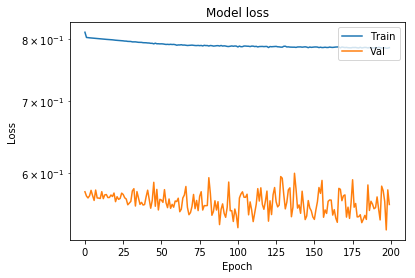

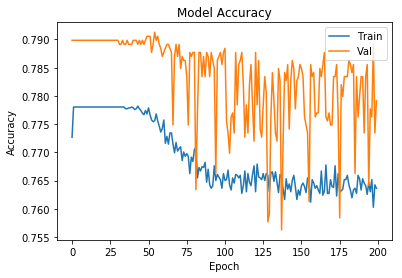

In [12]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.yscale('linear')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

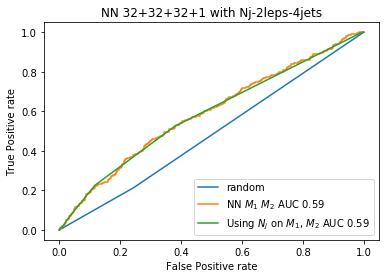

In [18]:
y_true = Y_test

Ytoshuffle=np.zeros(len(Y_test))
for i in range(len(Y_test)):
    Ytoshuffle[i]=Y_test[i]
np.random.shuffle(Ytoshuffle)
y_scoresrandom = Ytoshuffle
fprr, tprr, thresholdsr = metrics.roc_curve(y_true, y_scoresrandom)
plt.plot(fprr,tprr, label = 'random')

y_scores = model.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores)
plt.plot(fpr,tpr, label = 'NN $M_1$ $M_2$ AUC '+ str(round(roc_auc_score(y_true, y_scores),2)))

y_scores_Nj = X_test.T[0]
fpr_Nj, tpr_Nj, thresholds_Nj = metrics.roc_curve(y_true, y_scores_Nj)
plt.plot(fpr_Nj,tpr_Nj, label = 'Using $N_j$ on $M_1$, $M_2$ AUC '+ str(round(roc_auc_score(y_true, y_scores_Nj),2)))

plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.yscale('linear')
plt.title('NN 32+32+32+1 with Nj-2leps-4jets')
plt.legend(loc = 'lower right')

## Let's check the pdfs of the NN output for M1 vs M2 and S vs B

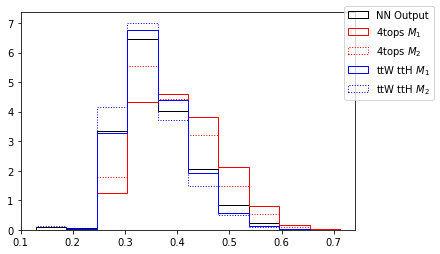

In [30]:
scores= model.predict_proba(X_scale)
tot=[]
s1=[]
s2=[]
b1=[]
b2=[]
m1=[]
m2=[]
n1s=0.0
n2s=0.0
n1b=0.0
n2b=0.0
for i in range(len(Ym1m2)):
    if(Y[i]==1 and Ym1m2[i]==1):
        n1s+=1.0
        tot.append(float(scores[i][0]))
        s1.append(float(scores[i][0]))
        m1.append(float(scores[i][0]))
    elif(Y[i]==1 and Ym1m2[i]==0):
        n2s+=1.0
        tot.append(float(scores[i][0]))
        s2.append(float(scores[i][0]))
        m2.append(float(scores[i][0]))
    elif(Y[i]==0 and Ym1m2[i]==1):
        n1b+=1.0
        tot.append(float(scores[i][0]))
        b1.append(float(scores[i][0]))
        m1.append(float(scores[i][0]))
    elif(Y[i]==0 and Ym1m2[i]==0):
        n2b+=1.0
        tot.append(float(scores[i][0]))
        b2.append(float(scores[i][0]))
        m2.append(float(scores[i][0]))

    else:
        print('Something is wrong')

f1s = float(n1s/len(m1))
f2s= float(n2s/len(m2))
f1b = float(n1b/len(m1))
f2b= float(n2b/len(m2))

bins1=[0.2+0.005*i for i in range(100)]
ptot, binstot, patchstot = plt.hist(tot,histtype='step', color='black', linestyle='-',label='NN Output',density='True')
ps1, binss1, patchs1 = plt.hist(s1,histtype='step',bins=binstot,color='red', linestyle='-',density='true',label='4tops $M_1$')
ps2, binss2, patchs2 = plt.hist(s2,histtype='step',bins=binss1, color='red', linestyle=':',density='true',label='4tops $M_2$')
pb1, binsb1, patchb1 = plt.hist(b1,histtype='step',bins=binss1, color = 'blue', linestyle='-',density='true',label='ttW ttH $M_1$')
pb2, binsb2, patchb2 = plt.hist(b2,histtype='step',bins=binss1, color = 'blue',linestyle=':',density='true',label='ttW ttH $M_2$')
pm1 = [f1s*ps1[i]+ (1-f1s)*pb1[i] for i in range(len(ps1))]
pm2 = [f2s*ps2[i]+ (1-f2s)*pb2[i] for i in range(len(ps1))]
plt.legend(bbox_to_anchor=(.95, 1.05))

Text(0, 0.5, 'p(O)')

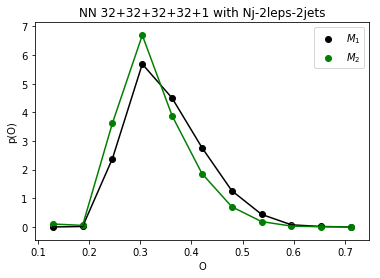

In [31]:
plt.plot(binss1,np.append(pm1,0),color = 'black')
plt.scatter(binss1,np.append(pm1,0),color = 'black',label='$M_1$')
plt.plot(binss1,np.append(pm2,0),color = 'green')
plt.scatter(binss1,np.append(pm2,0),color = 'green',label='$M_2$')
plt.title('NN 32+32+32+32+1 with Nj-2leps-2jets')
plt.legend(loc='upper right')
plt.xlabel('O')
plt.ylabel('p(O)')

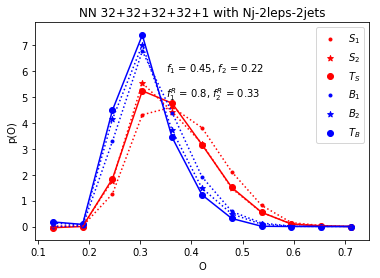

In [34]:
bins1=binss1
f1r = round(demixer(pm1,pm2)[1][0],2)
f2r=round(demixer(pm1,pm2)[1][1],2)
demix0=demixer(pm1,pm2)[0][0]
demix1=demixer(pm1,pm2)[0][1]
plt.scatter(bins1,np.append(ps1,0),color='red', marker = '.',label='$S_{1}$')
plt.text(0.35, 6, '$f_1$ = '+str(round(f1s,2))+', $f_2$ = '+ str(round(f2s,2)))
plt.text(0.35, 5, '$f^{R}_1$ = '+str(f1r)+', $f^{R}_2$ = '+ str(f2r))
plt.plot(bins1,np.append(ps1,0),color='red', linestyle=':')
plt.scatter(bins1,np.append(ps2,0),color='red',  marker = '*',label='$S_2$')
plt.scatter(bins1,np.append(demix0,0),color='red', marker = 'o',label='$T_{S}$')
plt.plot(bins1,np.append(demix0,0),color='red', linestyle='-')
plt.plot(bins1,np.append(ps2,0),color='red', linestyle=':')
plt.scatter(bins1,np.append(pb1,0),color='blue', marker = '.',label='$B_1$')
plt.plot(bins1,np.append(pb1,0),color='blue', linestyle=':')
plt.scatter(bins1,np.append(pb2,0),color='blue',  marker = '*',label='$B_{2}$')
plt.plot(bins1,np.append(pb2,0),color='blue', linestyle=':')
plt.scatter(bins1,np.append(demix1,0),color='blue', marker = 'o',label='$T_{B}$')
plt.plot(bins1,np.append(demix1,0),color='blue', linestyle='-')
plt.title('NN 32+32+32+32+1 with Nj-2leps-2jets')
plt.xlabel('O')
plt.ylabel('p(O)')
plt.legend(loc='upper right')